# Graph Training Sandbox

In [1]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt
sys.path.append('..')

sys.path.append('/global/common/cori_cle7/software/jupyter/19-11/lib/python3.7/site-packages')
sys.path.append('/global/homes/d/danieltm/.local/lib/python3.7/site-packages')

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import torch
import torch.multiprocessing as mp
import torch.nn as nn
# mp.set_start_method("forkserver", force=True)
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_scatter import scatter_add
import seaborn as sns
import wandb
# os.environ['WANDB_MODE'] = 'dryrun'

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '1'

# Local imports
from utils.toy_utils import *
%matplotlib inline

## Loading TrackML Dataset

In [6]:
%ls $SCRATCH/ExaTrkX/node_tracker_data/
g1 = np.load("/global/cscratch1/sd/danieltm/ExaTrkX/node_tracker_data/hitgraphs_med_000/event000001000_g000.npz")

hitgraphs_med_000/


In [2]:
input_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/node_tracker_data/hitgraphs_med_000/"
filenames = [os.path.join(input_dir, f) for f in os.listdir(input_dir)
                         if f.endswith('.npz') and not f.endswith('_ID.npz')]

In [3]:
full_graphs = [load_graph(fi) for fi in filenames]

In [5]:
cut_mask = [~(np.isnan(g[3]).any()) for g in full_graphs]
cut_full_graphs = np.array(full_graphs)[cut_mask].tolist()

In [4]:
cut_full_dataset = [torch_geometric.data.Data(x=torch.from_numpy(di[0]),
                                         edge_index=torch.from_numpy(di[1]), y_edges=torch.from_numpy(di[2]), 
                                         y_params=(torch.from_numpy(di[3][:,0]).unsqueeze(1)), pid=torch.from_numpy(di[4])) for di in full_graphs]

## Visualise data

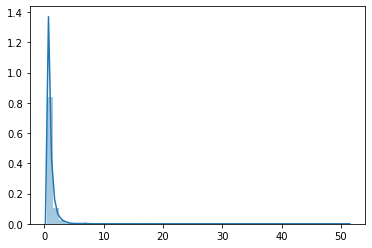

In [49]:
sns.distplot(np.concatenate(np.array([di[3][:,0] for di in full_graphs]))[:100000])

## Constructing PyG Datastructure

In [5]:
train_dataset = [gen_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(1000)]
test_dataset = [gen_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(500)]

In [6]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using ", device)
# model = Edge_Class_Net( input_dim=2, hidden_dim=64, n_graph_iters=4).to(device)
model = Net(train_dataset).to(device)
# data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-3)

Using  cuda


## Edge Classification Testing

In [51]:
model.train()
loss_v = []
acc_v = []
ep = 0
for epoch in range(500):
    ep += 1
    correct = 0
    total = 0
    for batch in train_loader:
#         print(batch.x)
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float())
        loss.backward()
        optimizer.step()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
#         print(correct, pred, data.y)
        total += len(pred)
#         print(out, data.y, )
    acc = correct/total
    print("Epoch: " , ep, ", loss: ", loss.item(), ", accuracy: ", acc)
    loss_v.append(loss)
    acc_v.append(acc)
plt.plot(np.arange(len(loss_v)), loss_v)
plt.plot(np.arange(len(acc_v)), acc_v)
plt.ylim(0.1,1)

Epoch:  1 , loss:  0.5512356758117676 , accuracy:  0.6864395625058761
Epoch:  2 , loss:  0.5046652555465698 , accuracy:  0.7436710645899276
Epoch:  3 , loss:  0.48637688159942627 , accuracy:  0.7629634272462315
Epoch:  4 , loss:  0.47630026936531067 , accuracy:  0.7705349587890564
Epoch:  5 , loss:  0.4798726439476013 , accuracy:  0.7736814064997336
Epoch:  6 , loss:  0.4695682227611542 , accuracy:  0.7731611770973706
Epoch:  7 , loss:  0.4612908959388733 , accuracy:  0.7738506377511047
Epoch:  8 , loss:  0.44322115182876587 , accuracy:  0.7768779968034097
Epoch:  9 , loss:  0.46184107661247253 , accuracy:  0.7758438058228087
Epoch:  10 , loss:  0.43595728278160095 , accuracy:  0.7730358206148735
Epoch:  11 , loss:  0.40324726700782776 , accuracy:  0.7812466702184336
Epoch:  12 , loss:  0.3373474180698395 , accuracy:  0.7961014133943402
Epoch:  13 , loss:  0.27982667088508606 , accuracy:  0.8321476699363816
Epoch:  14 , loss:  0.2253979742527008 , accuracy:  0.8571813594910527
Epoch:  

KeyboardInterrupt: 

In [52]:
model.eval()
for batch in test_loader:
    print(batch)
    data = batch.to(device)
    pred = model(data)
    correct = ((pred > 0.5) == (data.y > 0.5)).sum().item()
    acc = correct / len(pred)
    print('Accuracy: {:.4f}'.format(acc))

Batch(batch=[5930], edge_index=[2, 14580], x=[5930, 2], y=[14580])
Accuracy: 0.9812
Batch(batch=[5880], edge_index=[2, 14637], x=[5880, 2], y=[14637])
Accuracy: 0.9832
Batch(batch=[5580], edge_index=[2, 14190], x=[5580, 2], y=[14190])
Accuracy: 0.9862
Batch(batch=[5710], edge_index=[2, 14652], x=[5710, 2], y=[14652])
Accuracy: 0.9838
Batch(batch=[5470], edge_index=[2, 12952], x=[5470, 2], y=[12952])
Accuracy: 0.9866


## Track Count Testing


In [9]:
train_dataset = [gen_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(1000)]
test_dataset = [gen_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(500)]

In [10]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using ", device)
# model = Edge_Class_Net( input_dim=2, hidden_dim=64, n_graph_iters=4).to(device)
model = Net(train_dataset).to(device)
# data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

Using  cuda


In [12]:
model.train()
loss_v = []
acc_v = []
ep = 0
for epoch in range(500):
    ep += 1
    correct = 0
    total = 0
    for batch in train_loader:
#         print(batch.x)
        optimizer.zero_grad()
        data = batch.to(device)
        out = model(data)
        _, pred = out.max(dim=1)
        print(pred.shape, data.y.shape, pred, data.y)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        
        correct += float(pred.eq(data.y).sum().item())
#         print(correct, pred, data.y)
        total += len(pred)
#         print(out, data.y, )
    acc = correct/total
    print("Epoch: " , ep, ", loss: ", loss.item(), ", accuracy: ", acc)
    loss_v.append(loss)
    acc_v.append(acc)
plt.plot(np.arange(len(loss_v)), loss_v)
plt.plot(np.arange(len(acc_v)), acc_v)
plt.ylim(0.1,1)

torch.Size([100]) torch.Size([100]) tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6], device='cuda:0') tensor([ 9,  9,  7,  4,  7,  3,  5,  7,  6,  7,  4,  7,  2,  6,  5,  6,  7,  9,
         5,  9,  6,  9,  5,  7,  8,  8,  4,  4,  7,  5,  6,  4,  4,  8, 10,  1,
         5,  8,  8,  5,  8,  4,  9,  5,  9,  6,  2,  9,  5,  4,  7,  4,  9,  5,
         9,  5,  5,  4,  9,  6,  5,  7,  6,  4,  7,  4, 11,  4, 11,  5,  7,  4,
         7,  7,  9,  5,  3,  7,  3,  6,  3,  8,  3,  6,  6,  4,  6,  4,  8,  3,
         7,  7,  8,  2,  6,  6,  3,  4,  8,  2], device='cuda:0')
torch.Size([100]) torch.Size([100]) tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6

KeyboardInterrupt: 

In [23]:
model.eval()
for batch in test_loader:
    print(batch)
    data = batch.to(device)
    _, pred = model(data).max(dim=1)
    print(pred, data.y)
    correct = float(pred.eq(data.y).sum().item())
    acc = correct / len(pred)
    print('Accuracy: {:.4f}'.format(acc))

Batch(batch=[6110], edge_index=[2, 16297], x=[6110, 2], y=[100])
tensor([ 7,  7,  7,  4,  6,  4,  6,  9,  7,  9,  8,  2,  5,  6,  5,  6,  7,  7,
         9,  7,  4,  7,  9,  9,  5,  8,  5,  5,  4,  9,  7,  4,  9,  3,  9,  4,
         6,  5,  4,  6,  4,  7,  3,  5,  5,  4,  5,  5, 10,  5,  2,  7,  9,  6,
        10,  4,  3,  9,  4,  9,  4,  8,  6,  9,  9,  5,  1,  9,  7,  9,  5,  4,
         9,  6,  4,  9,  4,  4,  3,  7,  7,  9,  4,  4,  3,  7,  7,  4,  6,  9,
         7,  9, 10,  7,  9,  4, 10,  5,  7,  6], device='cuda:0') tensor([ 7,  7,  8,  4,  6,  4,  5, 11,  8, 10,  8,  3,  5,  6,  4,  6,  7,  6,
         8,  7,  4,  7,  9,  8,  5,  8,  5,  5,  2, 10,  7,  5,  9,  2,  8,  4,
         6,  5,  4,  6,  4,  7,  3,  5,  6,  5,  5,  6, 10,  5,  2,  6,  7,  6,
        11,  4,  3,  9,  3,  9,  4,  8,  6,  8,  6,  6,  2,  8,  7,  8,  5,  4,
         6,  5,  3,  9,  4,  3,  3,  6,  8, 10,  5,  4,  3,  7,  9,  4,  6,  5,
         7,  9,  9,  7, 10,  4, 11,  5,  6,  6], device='cuda:0')
Acc

## Combined Counter & Classifier

In [8]:
train_dataset = [gen_edge_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(1000)]
test_dataset = [gen_edge_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(500)]

In [9]:
train_dataset[0].y_graph.item()

6

In [5]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using ", device)
# model = Edge_Class_Net( input_dim=2, hidden_dim=64, n_graph_iters=4).to(device)
model = Edge_Graph_Class_Net(input_dim=2, hidden_dim=16, n_graph_iters=4, output_dim=12).to(device)
# data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

Using  cuda


In [23]:
model.train()
loss_v = []
acc_v_count = []
acc_v_edge = []
ep = 0
for epoch in range(500):
    ep += 1
    count_correct = 0
    edge_correct = 0
    count_total = 0
    edge_total = 0 
    for batch in train_loader:
#         print(batch.x)
        optimizer.zero_grad()
        data = batch.to(device)
        edge_pred, graph_pred = model(data)
        _, graph_pred_max = graph_pred.max(dim=1)
        losses = [F.binary_cross_entropy_with_logits(edge_pred.float(), data.y.float()), F.cross_entropy(graph_pred, data.y_graph)]
#         print(losses[0].item(), losses[1].item())
        loss = sum(losses)
        loss.backward()
        optimizer.step()

        edge_correct += ((edge_pred > 0.5) == (data.y > 0.5)).sum().item()
        count_correct += float(graph_pred_max.eq(data.y_graph).sum().item())
#         print(correct, pred, data.y)
        count_total += len(graph_pred_max)
        edge_total += len(edge_pred)
#         print(out, data.y, )
    count_acc = count_correct/count_total
    edge_acc = edge_correct / edge_total
    print("Epoch: " , ep, ", loss: ", loss.item(), ", count accuracy: ", count_acc, ", edge accuracy: ", edge_acc)
    loss_v.append(loss)
    acc_v_count.append(count_acc)
    acc_v_edge.append(edge_acc)
plt.plot(np.arange(len(loss_v)), loss_v)
plt.plot(np.arange(len(acc_v_count)), acc_v_count)
plt.plot(np.arange(len(acc_v_edge)), acc_v_edge)
plt.ylim(0.1,1)

Epoch:  1 , loss:  3.1576285362243652 , count accuracy:  0.122 , edge accuracy:  0.6513064133016627
Epoch:  2 , loss:  3.1742045879364014 , count accuracy:  0.134 , edge accuracy:  0.6614945111382166
Epoch:  3 , loss:  3.0324511528015137 , count accuracy:  0.134 , edge accuracy:  0.6614945111382166
Epoch:  4 , loss:  3.011707305908203 , count accuracy:  0.158 , edge accuracy:  0.6614945111382166
Epoch:  5 , loss:  3.0208494663238525 , count accuracy:  0.196 , edge accuracy:  0.6620851255055531
Epoch:  6 , loss:  3.003718137741089 , count accuracy:  0.182 , edge accuracy:  0.6734865506837003
Epoch:  7 , loss:  2.8945674896240234 , count accuracy:  0.193 , edge accuracy:  0.6919881877126532
Epoch:  8 , loss:  2.9283816814422607 , count accuracy:  0.194 , edge accuracy:  0.7084547730628491
Epoch:  9 , loss:  2.8948309421539307 , count accuracy:  0.204 , edge accuracy:  0.7297875072221865
Epoch:  10 , loss:  2.914076328277588 , count accuracy:  0.208 , edge accuracy:  0.746857546382487
Epo

KeyboardInterrupt: 

In [11]:
model.eval()
for batch in test_loader:
    print(batch)
    data = batch.to(device)
    edge_pred, graph_pred = model(data)
    _, graph_pred_max = graph_pred.max(dim=1)
    correct = float(graph_pred_max.eq(data.y_graph).sum().item())
    acc = correct / len(graph_pred_max)
    print('Accuracy: {:.4f}'.format(acc))

Batch(batch=[5910], edge_index=[2, 14768], x=[5910, 2], y=[14768], y_graph=[100])
Accuracy: 0.6900
Batch(batch=[6130], edge_index=[2, 15735], x=[6130, 2], y=[15735], y_graph=[100])
Accuracy: 0.7000
Batch(batch=[6460], edge_index=[2, 17175], x=[6460, 2], y=[17175], y_graph=[100])
Accuracy: 0.6700
Batch(batch=[6180], edge_index=[2, 15944], x=[6180, 2], y=[15944], y_graph=[100])
Accuracy: 0.6800
Batch(batch=[6110], edge_index=[2, 15557], x=[6110, 2], y=[15557], y_graph=[100])
Accuracy: 0.8600


## Combined Edge & Track Param Classifier

In [2]:
class TwoHopAttNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, hidden_dim, output_dim, hidden_activation=nn.ReLU,
                 layer_norm=True):
        super(TwoHopAttNetwork, self).__init__()
        self.network = make_mlp(input_dim*5, [hidden_dim, hidden_dim, hidden_dim, output_dim],
                                hidden_activation=hidden_activation,
                                output_activation=hidden_activation,
                                layer_norm=layer_norm)

    def forward(self, x, e, edge_index):
        start, end = edge_index
        # Aggregate edge-weighted incoming/outgoing features
        mi = scatter_add(e[:, None] * x[start], end, dim=0, dim_size=x.shape[0])
        mi2 = scatter_add(e[:, None]*scatter_add(e[:, None] * x[start], end, dim=0, dim_size=x.shape[0])[start], end, dim=0, dim_size=x.shape[0])
        mo = scatter_add(e[:, None] * x[end], start, dim=0, dim_size=x.shape[0])
        mo2 = scatter_add(e[:, None]*scatter_add(e[:, None] * x[end], start, dim=0, dim_size=x.shape[0])[end], start, dim=0, dim_size=x.shape[0])
        node_inputs = torch.cat([mi, mi2, mo, mo2, x], dim=1)
        return self.network(node_inputs)
    
def n_hop_front(x, e, edge_index, n):
    start, end = edge_index
#     print(n, "-hop forward shapes: ", x.shape, e.shape, edge_index.shape) 
    if n is 1:
        return [scatter_add(e[:,None]*x[start], end, dim=0, dim_size=x.shape[0])]
    else:
        running_hop = n_hop_front(x, e, edge_index, (n-1))
        forward_hop = [scatter_add(e[:, None]*(running_hop[0])[start], end, dim=0, dim_size=x.shape[0])]
        return forward_hop + running_hop

def n_hop_back(x, e, edge_index, n):
    start, end = edge_index
#     print(n, "-hop back shapes: ", x.shape, e.shape, edge_index.shape)
    if n is 1:
        return [scatter_add(e[:,None]*x[end], start, dim=0, dim_size=x.shape[0])]
    else:
        running_hop = n_hop_back(x, e, edge_index, (n-1))
        back_hop = [scatter_add(e[:, None]*(running_hop[0])[end], start, dim=0, dim_size=x.shape[0])]
        return back_hop + running_hop

class NHopAttNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, hidden_dim, output_dim, hidden_activation=nn.ReLU,
                 layer_norm=True, hops=1):
        super(NHopAttNetwork, self).__init__()
        self.network = make_mlp(input_dim*(hops*2 + 1), [hidden_dim, hidden_dim, hidden_dim, output_dim],
                                hidden_activation=hidden_activation,
                                output_activation=hidden_activation,
                                layer_norm=layer_norm)
        self.hops = hops
        
    def forward(self, x, e, edge_index):
#         print("Input shapes: ", x.shape, e.shape, edge_index.shape)       
        node_inputs = torch.cat(n_hop_front(x, e, edge_index, self.hops) + [x] + n_hop_back(x, e, edge_index, self.hops), dim=-1)
#         print("Network shape: ", node_inputs.shape)
        return self.network(node_inputs)
    

        
class TwoHopNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, hidden_dim, output_dim, hidden_activation=nn.ReLU,
                 layer_norm=True):
        super(TwoHopNetwork, self).__init__()
        self.network = make_mlp(input_dim*5, [hidden_dim, hidden_dim, hidden_dim, output_dim],
                                hidden_activation=hidden_activation,
                                output_activation=hidden_activation,
                                layer_norm=layer_norm)

    def forward(self, x, e, edge_index):
        start, end = edge_index
        # Aggregate edge-weighted incoming/outgoing features
        mi = scatter_add(x[start], end, dim=0, dim_size=x.shape[0])
        mi2 = scatter_add(scatter_add(x[start], end, dim=0, dim_size=x.shape[0])[start], end, dim=0, dim_size=x.shape[0])
        mo = scatter_add(x[end], start, dim=0, dim_size=x.shape[0])
        mo2 = scatter_add(scatter_add(x[end], start, dim=0, dim_size=x.shape[0])[end], start, dim=0, dim_size=x.shape[0])
        node_inputs = torch.cat([mi, mi2, mo, mo2, x], dim=1)
        return self.network(node_inputs)

class Edge_Track_Net(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, input_dim=3, hidden_dim=8, n_graph_iters=3,
                 output_dim=3, hidden_activation=nn.ReLU, layer_norm=True):
        super(Edge_Track_Net, self).__init__()
        self.n_graph_iters = n_graph_iters
        # Setup the input network
        self.input_network = make_mlp(input_dim, [hidden_dim],
                                      hidden_activation=nn.ReLU,
                                      layer_norm=False)
        # Setup the edge network
        self.edge_network = EdgeNetwork(input_dim+hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup the node layers
        self.node_network = TwoHopAttNetwork(input_dim+hidden_dim, hidden_dim, hidden_dim,
                                        hidden_activation=nn.ReLU, layer_norm=False)
        
#         self.output_network = NodeNetwork(input_dim+hidden_dim, hidden_dim, output_dim,
#                                         layer_norm=False)
        self.output_network = make_mlp(input_dim+hidden_dim, [hidden_dim, hidden_dim, output_dim],
                                       hidden_activation=nn.ReLU,
                                      output_activation=None,
                                      layer_norm=False)

    def forward(self, inputs):
        """Apply forward pass of the model"""
        # Apply input network to get hidden representation
        x = self.input_network(inputs.x)
        # Shortcut connect the inputs onto the hidden representation
        x = torch.cat([x, inputs.x], dim=-1)
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            # Apply edge network
            e = torch.sigmoid(self.edge_network(x, inputs.edge_index))
            # Apply node network
            x = self.node_network(x, e, inputs.edge_index)
            # Shortcut connect the inputs onto the hidden representation
            x = torch.cat([x, inputs.x], dim=-1)
        # Apply final edge network
        e = self.edge_network(x, inputs.edge_index)
        return e, self.output_network(x)
    
class Edge_Track_Truth_Net(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, input_dim=3, hidden_dim=8, n_graph_iters=3,
                 output_dim=3, hidden_activation=nn.ReLU, layer_norm=True):
        super(Edge_Track_Truth_Net, self).__init__()
        self.n_graph_iters = n_graph_iters
        # Setup the input network
        self.input_network = make_mlp(input_dim, [hidden_dim],
                                      hidden_activation=nn.ReLU,
                                      layer_norm=False)
        # Setup the node layers
        self.node_network = TwoHopAttNetwork(input_dim+hidden_dim, hidden_dim, hidden_dim,
                                        hidden_activation=nn.ReLU, layer_norm=False)
        
#         self.output_network = NodeNetwork(input_dim+hidden_dim, hidden_dim, output_dim,
#                                         layer_norm=False)
        self.output_network = make_mlp(input_dim+hidden_dim, [hidden_dim, hidden_dim, output_dim],
                                       hidden_activation=nn.ReLU,
                                      output_activation=None,
                                      layer_norm=False)

    def forward(self, inputs):
        """Apply forward pass of the model"""
        # Apply input network to get hidden representation
        x = self.input_network(inputs.x)
        # Shortcut connect the inputs onto the hidden representation
        x = torch.cat([x, inputs.x], dim=-1)
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            # Apply edge network
            e = inputs.y_edges
            # Apply node network
            x = self.node_network(x, e, inputs.edge_index)
            # Shortcut connect the inputs onto the hidden representation
            x = torch.cat([x, inputs.x], dim=-1)
        # Apply final edge network
        return self.output_network(x)
    
class NHop_Edge_Class_Net(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, input_dim=3, hidden_dim=8, n_graph_iters=3,
                 hidden_activation=nn.Tanh, layer_norm=True, hops=1):
        super(NHop_Edge_Class_Net, self).__init__()
        self.n_graph_iters = n_graph_iters
        # Setup the input network
        self.input_network = make_mlp(input_dim, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        # Setup the edge network
        self.edge_network = EdgeNetwork(input_dim+hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup the node layers
        self.node_network = NHopAttNetwork(input_dim+hidden_dim, hidden_dim, hidden_dim,
                                        hidden_activation=nn.ReLU, layer_norm=False, hops=hops)

    def forward(self, inputs):
        """Apply forward pass of the model"""
        # Apply input network to get hidden representation
        x = self.input_network(inputs.x)
        # Shortcut connect the inputs onto the hidden representation
        x = torch.cat([x, inputs.x], dim=-1)
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            # Apply edge network
            e = torch.sigmoid(self.edge_network(x, inputs.edge_index))
            # Apply node network
            x = self.node_network(x, e, inputs.edge_index)
            # Shortcut connect the inputs onto the hidden representation
            x = torch.cat([x, inputs.x], dim=-1)
        # Apply final edge network
        return self.edge_network(x, inputs.edge_index)
    

#### Load data

In [6]:
train_size, val_size = 200, 10
train_dataset, val_dataset = load_data(train_size, val_size)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
t_configs = {'train_size': train_size, 'val_size': val_size}

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print("Using ", device)
m_configs = {'hidden_dim': 64, 'n_graph_iters': 4, 'hops': 4}
m_configs = {'input_dim': 3, **m_configs}#, 'output_dim': 1}
model = NHop_Edge_Class_Net(**m_configs).to(device)
# data = dataset[0].to(device)
o_configs = {'lr': 0.001, 'weight_decay': 1e-4}
# optimizer = torch.optim.SGD([
#                                 {'params': model.input_network.parameters()},
#                                 {'params': model.edge_network.parameters()},
#                                 {'params': model.node_network.parameters()},
#                                 {'params': model.output_network.parameters(), 'lr': learning_rate*10}], lr=learning_rate, momentum=0.9)
# optimizer = torch.optim.Adam([
#                                 {'params': model.input_network.parameters()},
#                                 {'params': model.edge_network.parameters()},
#                                 {'params': model.node_network.parameters(), 'lr': learning_rate*10},
#                                 {'params': model.output_network.parameters(), 'lr': learning_rate*10}], lr=learning_rate, weight_decay=1e-4)
optimizer = torch.optim.AdamW(model.parameters(), amsgrad=True, **o_configs)
s_configs = {'step_size': 20, 'gamma': 0.9}
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, **s_configs)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)

Using  cuda


In [9]:
hyperconfig = {**m_configs, **t_configs, **s_configs, **o_configs}
wandb.init(project="node_regression", config=hyperconfig)
wandb.watch(model, log='all')

wandb: Network error resolved after 0:00:23.785435, resuming normal operation.
wandb: psutil not installed, only GPU stats will be reported.  Install with pip install psutil
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


wandb: Network error resolved after 0:00:11.332204, resuming normal operation.
wandb: Network error resolved after 0:00:23.334204, resuming normal operation.
wandb: Network error resolved after 0:00:37.807275, resuming normal operation.
wandb: Network error resolved after 0:00:38.484777, resuming normal operation.


### Training and Validation

In [23]:
def edge_validate(model, val_loader, val_size):
    model = model.eval()
    edge_correct, edge_total, loss = 0, 0, 0
    for batch in val_loader:
        data = batch.to(device)
#             print(len(data.y_params))
        edge_pred = model(data)
        edge_pred = torch.sigmoid(edge_pred)
        edge_correct += ((edge_pred > 0.5) == (data.y_edges > 0.5)).sum().item()
        edge_total += len(edge_pred)
        loss += F.binary_cross_entropy_with_logits(edge_pred, data.y_edges)
    acc = edge_correct / edge_total
    return acc, loss.item()/val_size

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

Epoch:  1 , val loss:  0.07246202230453491 , val accuracy:  83.40630249961819 %, lr:  0.001
Epoch:  2 , val loss:  0.07213714718818665 , val accuracy:  83.49812001367263 %, lr:  0.001
Epoch:  3 , val loss:  0.06964496970176696 , val accuracy:  83.77357255583597 %, lr:  0.001
Epoch:  4 , val loss:  0.06716558933258057 , val accuracy:  91.62060639558986 %, lr:  0.001
Epoch:  5 , val loss:  0.06460346579551697 , val accuracy:  94.32604126515443 %, lr:  0.001
Epoch:  6 , val loss:  0.06392822265625 , val accuracy:  95.3200340361161 %, lr:  0.001
Epoch:  7 , val loss:  0.06388763785362243 , val accuracy:  95.47185111381008 %, lr:  0.001
Epoch:  8 , val loss:  0.06356757283210754 , val accuracy:  95.82166675151453 %, lr:  0.001
Epoch:  9 , val loss:  0.06293382048606873 , val accuracy:  96.00221089301169 %, lr:  0.001
Epoch:  10 , val loss:  0.06370933055877685 , val accuracy:  95.75275816175882 %, lr:  0.001
Epoch:  11 , val loss:  0.06264554262161255 , val accuracy:  96.32384491749151 %, l

Epoch:  82 , val loss:  0.062348181009292604 , val accuracy:  97.73492556417771 %, lr:  2.6999999999999996e-05
Epoch:  83 , val loss:  0.06194225549697876 , val accuracy:  97.74201642169875 %, lr:  2.6999999999999996e-05
Epoch:  84 , val loss:  0.062429362535476686 , val accuracy:  97.73710736649188 %, lr:  2.6999999999999996e-05
Epoch:  85 , val loss:  0.06345455050468445 , val accuracy:  97.74165278797973 %, lr:  2.6999999999999996e-05
Epoch:  86 , val loss:  0.06195130944252014 , val accuracy:  97.74947091293882 %, lr:  2.6999999999999996e-05
Epoch:  87 , val loss:  0.061946827173233035 , val accuracy:  97.74874364550075 %, lr:  2.6999999999999996e-05
Epoch:  88 , val loss:  0.06194523572921753 , val accuracy:  97.74419822401292 %, lr:  2.6999999999999996e-05
Epoch:  89 , val loss:  0.06319805979728699 , val accuracy:  97.75347088384811 %, lr:  8.099999999999999e-06
Epoch:  90 , val loss:  0.062324315309524536 , val accuracy:  97.75419815128618 %, lr:  8.099999999999999e-06
Epoch:  

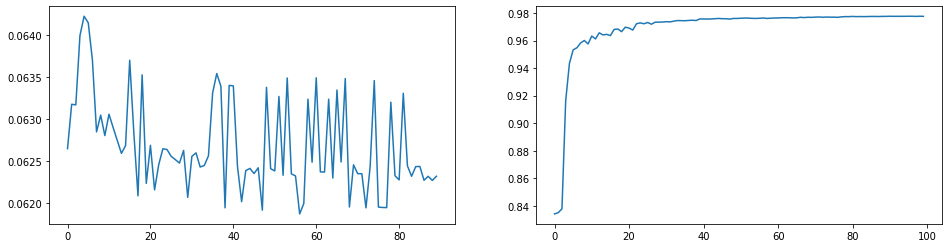

In [24]:
model.train()
# loss_v_node = []
loss_v_edge = []
# acc_v_node = []
acc_v_edge = []
ep, lr = 0, get_lr(optimizer)

while (lr > 6e-6):
    ep += 1
#     node_correct = 0
    edge_correct = 0
#     node_total = 0
    edge_total = 0 
    for batch in train_loader:
#         print(batch)
        optimizer.zero_grad()
        data = batch.to(device)
        edge_pred = model(data)
#         print(edge_pred.shape, data.y_edges.shape, node_pred.shape, data.y_params.shape)
#         print(edge_pred, data.y_edges, node_pred, data.y_params)
#         losses = [F.binary_cross_entropy_with_logits(edge_pred.float(), data.y_edges.float()), F.mse_loss(node_pred.float(), data.y_params.float())]
#         print(node_pred, data.y_nodes)
#         print("Losses: ", losses[0].item(), losses[1].item())
#         loss = F.mse_loss(node_pred, data.y_params)
        loss = F.binary_cross_entropy_with_logits(edge_pred, data.y_edges)
#         loss = sum(losses)
#         loss_v_edge.append(loss)
#         loss_v_node.append(loss)
        loss.backward()
        optimizer.step()
#         edge_pred = torch.sigmoid(edge_pred)
#         edge_correct += ((edge_pred > 0.5) == (data.y_edges > 0.5)).sum().item()
        # A "correct" track parameter is one where the pred. is within 5% of the truth
#         print(node_pred, data.y_nodes)
#         print((((node_pred - data.y_nodes)/data.y_nodes)**2 < 0.05**2).sum().item())
#         node_correct += (((node_pred - data.y_params)/data.y_params)**2 < 0.1**2).sum().item()
#         node_total += len(node_pred)
#         edge_total += len(edge_pred)
#         print(out, data.y, )
#     node_acc = node_correct/node_total
#     edge_acc = edge_correct / edge_total
    
        
    val_acc, val_loss = edge_validate(model, val_loader, 10)
    scheduler.step(val_loss)
    lr = get_lr(optimizer)
#     print("Epoch: " , ep, ", loss: ", loss.item(), ", node accuracy: ", node_acc*100, "%, edge accuracy: ", edge_acc*100, "%, lr: ", scheduler.get_lr())
    print("Epoch: " , ep, ", val loss: ", val_loss, ", val accuracy: ", val_acc*100, "%, lr: ", lr)
#     acc_v_node.append(node_acc)
#     wandb.log({"Test Accuracy": node_acc, "Test Loss": loss.item(), "Learning Rate": scheduler.get_lr()[0]})
    acc_v_edge.append(val_acc)
    loss_v_edge.append(val_loss)

#     if node_acc > 0.5:
#         break
fig, axs = plt.subplots(1,2)
fig.set_size_inches(16,4)
# axs[0].plot(np.arange(len(loss_v_node)-10), loss_v_node[10:])
axs[0].plot(np.arange(len(loss_v_edge)-10), loss_v_edge[10:])
# axs[1].plot(np.arange(len(acc_v_node)), acc_v_node)
axs[1].plot(np.arange(len(acc_v_edge)), acc_v_edge)

In [52]:
model.eval()
for batch in test_loader:
#     print(batch)
    data = batch.to(device)
    node_pred = model(data)
#     edge_pred = torch.sigmoid(edge_pred)
#     print(edge_pred, data.y_edges, node_pred, data.y_params)
    print(node_pred, data.y_params)
#     edge_correct = ((edge_pred > 0.5) == (data.y_edges > 0.5)).sum().item()
    correct = (((node_pred - data.y_params)/data.y_params)**2 < 0.1**2).sum().item()
    acc = correct / (len(node_pred))*100
#     edge_acc = edge_correct / len(edge_pred)*100
#     print('Accuracy: {:.4f}%'.format(acc), ', edge accuracy: {:.4f}%'.format(edge_acc))
    print('Accuracy: {:.4f}%'.format(acc))

tensor([[ 8.9318],
        [11.8650],
        [11.2290],
        ...,
        [ 0.7272],
        [ 0.6703],
        [ 0.7702]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[15.2125],
        [15.2125],
        [15.2125],
        ...,
        [ 0.5958],
        [ 0.5958],
        [ 0.5958]], device='cuda:0')
Accuracy: 39.7417%
tensor([[13.8930],
        [14.0282],
        [17.2821],
        ...,
        [ 1.9400],
        [ 1.5565],
        [ 1.8785]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[40.8148],
        [40.8148],
        [40.8148],
        ...,
        [ 1.7936],
        [ 1.7936],
        [ 1.7936]], device='cuda:0')
Accuracy: 40.2185%
tensor([[0.6895],
        [0.6651],
        [0.6577],
        ...,
        [1.0724],
        [1.4556],
        [1.4310]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[18.9864],
        [18.9864],
        [18.9864],
        ...,
        [ 0.6766],
        [ 0.6766],
        [ 0.6766]], device='cuda:0')
Accuracy: 40.0350%
tens

        [0.6972]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[34.2068],
        [34.2068],
        [34.2068],
        ...,
        [ 0.5591],
        [ 0.5591],
        [ 0.5591]], device='cuda:0')
Accuracy: 40.2999%
tensor([[10.2161],
        [ 8.5189],
        [ 7.6812],
        ...,
        [ 0.6470],
        [ 0.6614],
        [ 0.5862]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[12.3305],
        [12.3305],
        [12.3305],
        ...,
        [ 0.5768],
        [ 0.5768],
        [ 0.5768]], device='cuda:0')
Accuracy: 40.0605%
tensor([[0.9681],
        [1.0175],
        [1.0679],
        ...,
        [0.6423],
        [0.6531],
        [0.6582]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[2.1535],
        [2.1535],
        [2.1535],
        ...,
        [0.5419],
        [0.5419],
        [0.5419]], device='cuda:0')
Accuracy: 39.3605%
tensor([[0.9883],
        [0.9892],
        [0.9956],
        ...,
        [0.7058],
        [0.7919],
        [0.9199]

tensor([[0.9016],
        [1.0014],
        [1.2399],
        ...,
        [0.6275],
        [0.6268],
        [0.6755]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[1.0432],
        [1.0432],
        [1.0432],
        ...,
        [0.6954],
        [0.6954],
        [0.6954]], device='cuda:0')
Accuracy: 39.1318%
tensor([[0.9803],
        [0.9692],
        [0.9925],
        ...,
        [0.5200],
        [0.5255],
        [0.5377]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[5.4676],
        [5.4676],
        [5.4676],
        ...,
        [0.5036],
        [0.5036],
        [0.5036]], device='cuda:0')
Accuracy: 39.6506%
tensor([[19.0480],
        [23.0835],
        [21.6653],
        ...,
        [ 1.5495],
        [ 1.5566],
        [ 1.3213]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[66.0761],
        [66.0761],
        [66.0761],
        ...,
        [ 1.1489],
        [ 1.1489],
        [ 1.1489]], device='cuda:0')
Accuracy: 39.7656%
tensor([[10.7145],
   

### Debug

In [10]:
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_max_memory_cached()
print(torch.cuda.memory_allocated(0)/1024**3, torch.cuda.max_memory_allocated(0)/1024**3)

0.0 0.0


## Getting Weights & Bias to Work

In [18]:
model.output_network

Sequential(
  (0): Linear(in_features=19, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
)

Retry attempt failed:
Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/util/connection.py", line 84, in create_connection
    raise err
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/util/connection.py", line 74, in create_connection
    sock.connect(sa)
OSError: [Errno 101] Network is unreachable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/global/homes/d/danieltm/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/urllib3/con

## Sweep

In [33]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt
sys.path.append('..')
sys.path.append('/global/common/cori_cle7/software/jupyter/19-11/lib/python3.7/site-packages')
sys.path.append('/global/homes/d/danieltm/.local/lib/python3.7/site-packages')
import wandb
# External imports
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import yaml

In [37]:
with open(r'config.yaml') as file:
    sweep_config = yaml.load(file, Loader=yaml.FullLoader)
sweep_id = wandb.sweep(sweep_config, entity= "murnanedaniel", project= "node_regression_sweep")

{'method': 'bayes',
 'metric': {'goal': 'maximize', 'name': 'Best Accuracy'},
 'name': 'Track Param Sweep',
 'parameters': {'epochs': {'distribution': 'q_normal',
   'max': 250,
   'min': 50,
   'mu': 150,
   'sigma': 50},
  'hidden_dim': {'distribution': 'q_log_normal',
   'max': 4.159,
   'min': 1.386,
   'mu': 2.8,
   'sigma': 0.8},
  'lr': {'distribution': 'log_normal',
   'max': -2.3,
   'min': -11.5,
   'mu': -6.9,
   'sigma': 1.5},
  'n_graph_iters': {'max': 8, 'min': 1},
  'network': {'values': ['Edge_Track_Truth_Net']},
  'optimizer': {'values': ['AdamW']},
  'train_size': {'max': 800, 'min': 100},
  'weight_decay': {'distribution': 'log_uniform', 'max': -4.6, 'min': -11.5}}}

In [32]:
def train():
           
    print("Initialising W&B...")
    wandb.init()

    from torch_geometric.data import Data
    from torch_geometric.data import DataLoader
    from torch_scatter import scatter_add
    
    # Local imports
    from utils.toy_utils import load_data, make_mlp

    class TwoHopAttNetwork(nn.Module):
        """
        A module which computes new node features on the graph.
        For each node, it aggregates the neighbor node features
        (separately on the input and output side), and combines
        them with the node's previous features in a fully-connected
        network to compute the new features.
        """
        def __init__(self, input_dim, hidden_dim, output_dim, hidden_activation=nn.ReLU,
                     layer_norm=True):
            super(TwoHopAttNetwork, self).__init__()
            self.network = make_mlp(input_dim*5, [hidden_dim, hidden_dim, hidden_dim, output_dim],
                                    hidden_activation=hidden_activation,
                                    output_activation=hidden_activation,
                                    layer_norm=layer_norm)

        def forward(self, x, e, edge_index):
            start, end = edge_index
            # Aggregate edge-weighted incoming/outgoing features
            mi = scatter_add(e[:, None] * x[start], end, dim=0, dim_size=x.shape[0])
            mi2 = scatter_add(e[:, None]*scatter_add(e[:, None] * x[start], end, dim=0, dim_size=x.shape[0])[start], end, dim=0, dim_size=x.shape[0])
            mo = scatter_add(e[:, None] * x[end], start, dim=0, dim_size=x.shape[0])
            mo2 = scatter_add(e[:, None]*scatter_add(e[:, None] * x[end], start, dim=0, dim_size=x.shape[0])[end], start, dim=0, dim_size=x.shape[0])
            node_inputs = torch.cat([mi, mi2, mo, mo2, x], dim=1)
            return self.network(node_inputs)

    class TwoHopNetwork(nn.Module):
        """
        A module which computes new node features on the graph.
        For each node, it aggregates the neighbor node features
        (separately on the input and output side), and combines
        them with the node's previous features in a fully-connected
        network to compute the new features.
        """
        def __init__(self, input_dim, hidden_dim, output_dim, hidden_activation=nn.ReLU,
                     layer_norm=True):
            super(TwoHopNetwork, self).__init__()
            self.network = make_mlp(input_dim*5, [hidden_dim, hidden_dim, hidden_dim, output_dim],
                                    hidden_activation=hidden_activation,
                                    output_activation=hidden_activation,
                                    layer_norm=layer_norm)

        def forward(self, x, e, edge_index):
            start, end = edge_index
            # Aggregate edge-weighted incoming/outgoing features
            mi = scatter_add(x[start], end, dim=0, dim_size=x.shape[0])
            mi2 = scatter_add(scatter_add(x[start], end, dim=0, dim_size=x.shape[0])[start], end, dim=0, dim_size=x.shape[0])
            mo = scatter_add(x[end], start, dim=0, dim_size=x.shape[0])
            mo2 = scatter_add(scatter_add(x[end], start, dim=0, dim_size=x.shape[0])[end], start, dim=0, dim_size=x.shape[0])
            node_inputs = torch.cat([mi, mi2, mo, mo2, x], dim=1)
            return self.network(node_inputs)

    class Edge_Track_Net(nn.Module):
        """
        Segment classification graph neural network model.
        Consists of an input network, an edge network, and a node network.
        """
        def __init__(self, input_dim=3, hidden_dim=8, n_graph_iters=3,
                     output_dim=3, hidden_activation=nn.ReLU, layer_norm=True):
            super(Edge_Track_Net, self).__init__()
            self.n_graph_iters = n_graph_iters
            # Setup the input network
            self.input_network = make_mlp(input_dim, [hidden_dim],
                                          hidden_activation=nn.ReLU,
                                          layer_norm=False)
            # Setup the edge network
            self.edge_network = EdgeNetwork(input_dim+hidden_dim, hidden_dim,
                                            hidden_activation, layer_norm=layer_norm)
            # Setup the node layers
            self.node_network = TwoHopAttNetwork(input_dim+hidden_dim, hidden_dim, hidden_dim,
                                            hidden_activation=nn.ReLU, layer_norm=False)

    #         self.output_network = NodeNetwork(input_dim+hidden_dim, hidden_dim, output_dim,
    #                                         layer_norm=False)
            self.output_network = make_mlp(input_dim+hidden_dim, [hidden_dim, hidden_dim, output_dim],
                                           hidden_activation=nn.ReLU,
                                          output_activation=None,
                                          layer_norm=False)

        def forward(self, inputs):
            """Apply forward pass of the model"""
            # Apply input network to get hidden representation
            x = self.input_network(inputs.x)
            # Shortcut connect the inputs onto the hidden representation
            x = torch.cat([x, inputs.x], dim=-1)
            # Loop over iterations of edge and node networks
            for i in range(self.n_graph_iters):
                # Apply edge network
                e = torch.sigmoid(self.edge_network(x, inputs.edge_index))
                # Apply node network
                x = self.node_network(x, e, inputs.edge_index)
                # Shortcut connect the inputs onto the hidden representation
                x = torch.cat([x, inputs.x], dim=-1)
            # Apply final edge network
            e = self.edge_network(x, inputs.edge_index)
            return e, self.output_network(x)

    class Edge_Track_Truth_Net(nn.Module):
        """
        Segment classification graph neural network model.
        Consists of an input network, an edge network, and a node network.
        """
        def __init__(self, input_dim=3, hidden_dim=8, n_graph_iters=3,
                     output_dim=3, hidden_activation=nn.ReLU, layer_norm=True):
            super(Edge_Track_Truth_Net, self).__init__()
            self.n_graph_iters = n_graph_iters
            # Setup the input network
            self.input_network = make_mlp(input_dim, [hidden_dim],
                                          hidden_activation=nn.ReLU,
                                          layer_norm=False)
            # Setup the node layers
            self.node_network = TwoHopAttNetwork(input_dim+hidden_dim, hidden_dim, hidden_dim,
                                            hidden_activation=nn.ReLU, layer_norm=False)

    #         self.output_network = NodeNetwork(input_dim+hidden_dim, hidden_dim, output_dim,
    #                                         layer_norm=False)
            self.output_network = make_mlp(input_dim+hidden_dim, [hidden_dim, hidden_dim, hidden_dim, output_dim],
                                           hidden_activation=nn.ReLU,
                                          output_activation=None,
                                          layer_norm=False)

        def forward(self, inputs):
            """Apply forward pass of the model"""
            # Apply input network to get hidden representation
            x = self.input_network(inputs.x)
            # Shortcut connect the inputs onto the hidden representation
            x = torch.cat([x, inputs.x], dim=-1)
            # Loop over iterations of edge and node networks
            for i in range(self.n_graph_iters):
                # Apply edge network
                e = inputs.y_edges
                # Apply node network
                x = self.node_network(x, e, inputs.edge_index)
                # Shortcut connect the inputs onto the hidden representation
                x = torch.cat([x, inputs.x], dim=-1)
            # Apply final edge network
            return self.output_network(x)

    def validate(model, val_loader, val_size):
        model = model.eval()
        node_correct, node_total, loss = 0, 0, 0
        for batch in val_loader:
            data = batch.to(device)
#             print(len(data.y_params))
            node_pred = model(data)
            node_correct += (((node_pred - data.y_params)/data.y_params)**2 < 0.1**2).sum().item()
            node_total += len(node_pred)
            loss += F.mse_loss(node_pred, data.y_params)
        acc = node_correct / node_total
        return acc, loss.item()/val_size

    def get_lr(optimizer):
        for param_group in optimizer.param_groups:
            return param_group['lr']
    
    print("Loading data...")
    train_dataset, val_dataset = load_data(train_size=wandb.config.get("train_size",0), test_size=20)
    train_loader, val_loader = DataLoader(train_dataset, batch_size=2, shuffle=True), DataLoader(val_dataset, batch_size=1, shuffle=True)
    
    print("config:", dict(wandb.config.user_items()))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Using ", device)
    
    m_dic = ["hidden_dim", "n_graph_iters"]
    m_configs = {k:wandb.config.get(k,0) for k in m_dic} 
    m_configs = {'input_dim': 3, **m_configs, 'output_dim': 1}
        
    print("Loading model...")
    print("Model configs: ", m_configs)
    model = Edge_Track_Truth_Net(**m_configs).to(device)
    wandb.watch(model, log='all')
    
    print("Loading optimiser")
    o_dic = ["lr", "weight_decay"]
    o_configs = {k:wandb.config.get(k,0) for k in o_dic} 
    optimizer_fn = getattr(torch.optim, wandb.config.get("optimizer",0))
#     optimizer_kwargs = {"Adam": {}, "SGD": {}}
    optimizer = optimizer_fn(model.parameters(), amsgrad=True, **o_configs)
    
    print("Loading scheduler...")
#     s_dic = ["step_size", "gamma"]
#     s_configs = {k:wandb.config.get(k,0) for k in s_dic} 
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 30)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10)
    
    model.train()
    
    print("Training...")
    
    ep, lr = 0, get_lr(optimizer)
    best_acc = 0
#     for epoch in range(wandb.config.get("epochs", 0)):
    while (lr > 6e-6):
        for batch in train_loader:
            optimizer.zero_grad()
            data = batch.to(device)
            node_pred = model(data)
            loss = F.mse_loss(node_pred, data.y_params)
            loss.backward()
            optimizer.step()
        ep += 1
        val_acc, val_loss = validate(model, val_loader, 20)
        if (val_acc > best_acc): best_acc = val_acc
        scheduler.step(val_loss)
        lr = get_lr(optimizer)
        print("Epoch: " , ep, ", validation loss: ", val_loss, ", validation accuracy: ", val_acc*100, "%, lr: ", lr)
        wandb.log({"Validation Accuracy": val_acc, "Best Accuracy": best_acc, "Validation Loss": val_loss, "Learning Rate": lr, "Epochs": ep})
            
wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: txex35gz with config:
	epochs: 173
	hidden_dim: 36
	lr: 0.002223379986022571
	n_graph_iters: 5
	network: Edge_Track_Truth_Net
	optimizer: AdamW
	train_size: 292
	weight_decay: 0.00021762208861989958
wandb: Agent Started Run: txex35gz
Initialising W&B...


wandb: psutil not installed, only GPU stats will be reported.  Install with pip install psutil
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.8.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Loading data...
config: {'epochs': 173, 'hidden_dim': 36, 'lr': 0.002223379986022571, 'n_graph_iters': 5, 'network': 'Edge_Track_Truth_Net', 'optimizer': 'AdamW', 'train_size': 292, 'weight_decay': 0.0002176220886198996}
Using  cuda
Loading model...
Model configs:  {'input_dim': 3, 'hidden_dim': 36, 'n_graph_iters': 5, 'output_dim': 1}
Loading optimiser
Loading scheduler...
Training...
Epoch:  1 , validation loss:  1.8970849990844727 , validation accuracy:  9.256994867244508 %, lr:  0.002223379986022571
Epoch:  2 , validation loss:  1.8765539169311523 , validation accuracy:  11.486839874620815 %, lr:  0.002223379986022571
Epoch:  3 , validation loss:  1.8755508422851563 , validation accuracy:  12.343501455422938 %, lr:  0.002223379986022571
Epoch:  4 , validation loss:  1.8715837478637696 , validation accuracy:  13.172389166026424 %, lr:  0.002223379986022571
Epoch:  5 , validation loss:  1.880539894104004 , validation accuracy:  10.921623581097897 %, lr:  0.002223379986022571
Epoch:  

Epoch:  66 , validation loss:  1.8681299209594726 , validation accuracy:  11.758446683186708 %, lr:  0.002223379986022571
Epoch:  67 , validation loss:  1.8448713302612305 , validation accuracy:  12.312841988320548 %, lr:  0.002223379986022571
Epoch:  68 , validation loss:  1.8441734313964844 , validation accuracy:  12.971840181215486 %, lr:  0.002223379986022571
Epoch:  69 , validation loss:  1.8767066955566407 , validation accuracy:  11.958634968384679 %, lr:  0.002223379986022571
Epoch:  70 , validation loss:  1.8767049789428711 , validation accuracy:  12.160987451260464 %, lr:  0.002223379986022571
Epoch:  71 , validation loss:  1.8770126342773437 , validation accuracy:  12.74820642117451 %, lr:  0.002223379986022571
Epoch:  72 , validation loss:  1.8766077041625977 , validation accuracy:  11.86341027056078 %, lr:  0.002223379986022571
Epoch:  73 , validation loss:  1.87622127532959 , validation accuracy:  12.381735614397686 %, lr:  0.002223379986022571
Epoch:  74 , validation loss

Epoch:  133 , validation loss:  1.8764049530029296 , validation accuracy:  12.549100234815446 %, lr:  3.474031228160267e-05
Epoch:  134 , validation loss:  1.876380157470703 , validation accuracy:  12.514473071970395 %, lr:  3.474031228160267e-05
Epoch:  135 , validation loss:  1.876397705078125 , validation accuracy:  12.537918546813398 %, lr:  3.474031228160267e-05
Epoch:  136 , validation loss:  1.8763849258422851 , validation accuracy:  12.536836447974492 %, lr:  3.474031228160267e-05
Epoch:  137 , validation loss:  1.8763813018798827 , validation accuracy:  12.560642622430466 %, lr:  3.474031228160267e-05
Epoch:  138 , validation loss:  1.8763824462890626 , validation accuracy:  12.554871428622958 %, lr:  3.474031228160267e-05
Epoch:  139 , validation loss:  1.8763835906982422 , validation accuracy:  12.554510729009987 %, lr:  3.474031228160267e-05
Epoch:  140 , validation loss:  1.8763805389404298 , validation accuracy:  12.563888918947189 %, lr:  3.474031228160267e-05
Epoch:  14

wandb: psutil not installed, only GPU stats will be reported.  Install with pip install psutil
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.8.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Loading data...
config: {'epochs': 157, 'hidden_dim': 17, 'lr': 0.001166754679869392, 'n_graph_iters': 3, 'network': 'Edge_Track_Truth_Net', 'optimizer': 'AdamW', 'train_size': 365, 'weight_decay': 3.582884498686503e-05}
Using  cuda
Loading model...
Model configs:  {'input_dim': 3, 'hidden_dim': 17, 'n_graph_iters': 3, 'output_dim': 1}
Loading optimiser
Loading scheduler...
Training...
Epoch:  1 , validation loss:  1.8794410705566407 , validation accuracy:  11.07888861235252 %, lr:  0.001166754679869392
Epoch:  2 , validation loss:  1.8830406188964843 , validation accuracy:  10.013381955641162 %, lr:  0.001166754679869392
Epoch:  3 , validation loss:  1.885198211669922 , validation accuracy:  9.734921854428851 %, lr:  0.001166754679869392
Epoch:  4 , validation loss:  1.8883790969848633 , validation accuracy:  9.53004447426228 %, lr:  0.001166754679869392
Epoch:  5 , validation loss:  1.8760457992553712 , validation accuracy:  10.700875417960678 %, lr:  0.001166754679869392
Epoch:  6 ,

Epoch:  66 , validation loss:  1.380025291442871 , validation accuracy:  12.0794693387294 %, lr:  0.001166754679869392
Epoch:  67 , validation loss:  1.3084972381591797 , validation accuracy:  24.209436623274502 %, lr:  0.001166754679869392
Epoch:  68 , validation loss:  1.136939239501953 , validation accuracy:  24.62640537586703 %, lr:  0.001166754679869392
Epoch:  69 , validation loss:  1.1580348014831543 , validation accuracy:  23.27883162181367 %, lr:  0.001166754679869392
Epoch:  70 , validation loss:  1.349592399597168 , validation accuracy:  20.41920509019294 %, lr:  0.001166754679869392
Epoch:  71 , validation loss:  1.581709384918213 , validation accuracy:  19.662818001796285 %, lr:  0.001166754679869392
Epoch:  72 , validation loss:  1.21463623046875 , validation accuracy:  23.463509823653958 %, lr:  0.001166754679869392
Epoch:  73 , validation loss:  1.6271135330200195 , validation accuracy:  22.11016487579309 %, lr:  0.001166754679869392
Epoch:  74 , validation loss:  1.056

Epoch:  134 , validation loss:  0.9458410263061523 , validation accuracy:  23.383795209187742 %, lr:  0.000291688669967348
Epoch:  135 , validation loss:  0.8861897468566895 , validation accuracy:  28.575344738655094 %, lr:  0.000291688669967348
Epoch:  136 , validation loss:  0.9067770957946777 , validation accuracy:  32.399121335742805 %, lr:  7.2922167491837e-05
Epoch:  137 , validation loss:  0.7916918754577636 , validation accuracy:  33.64425639971289 %, lr:  7.2922167491837e-05
Epoch:  138 , validation loss:  0.7788257598876953 , validation accuracy:  33.91622390789175 %, lr:  7.2922167491837e-05
Epoch:  139 , validation loss:  0.7676527500152588 , validation accuracy:  34.424088962952546 %, lr:  7.2922167491837e-05
Epoch:  140 , validation loss:  0.7918067932128906 , validation accuracy:  34.22173648007676 %, lr:  7.2922167491837e-05
Epoch:  141 , validation loss:  0.808712387084961 , validation accuracy:  33.72902080876067 %, lr:  7.2922167491837e-05
Epoch:  142 , validation lo

wandb: psutil not installed, only GPU stats will be reported.  Install with pip install psutil
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.8.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Loading data...
config: {'epochs': 180, 'hidden_dim': 19, 'lr': 0.0008020155923685281, 'n_graph_iters': 2, 'network': 'Edge_Track_Truth_Net', 'optimizer': 'AdamW', 'train_size': 363, 'weight_decay': 0.00015770158871663577}
Using  cuda
Loading model...
Model configs:  {'input_dim': 3, 'hidden_dim': 19, 'n_graph_iters': 2, 'output_dim': 1}
Loading optimiser
Loading scheduler...
Training...
Epoch:  1 , validation loss:  1.8813880920410155 , validation accuracy:  10.781311431652833 %, lr:  0.0008020155923685281
Epoch:  2 , validation loss:  1.879414939880371 , validation accuracy:  10.966350333106092 %, lr:  0.0008020155923685281
Epoch:  3 , validation loss:  1.8776962280273437 , validation accuracy:  10.761833652552491 %, lr:  0.0008020155923685281
Epoch:  4 , validation loss:  1.875347900390625 , validation accuracy:  11.569800785603757 %, lr:  0.0008020155923685281
Epoch:  5 , validation loss:  1.8758623123168945 , validation accuracy:  11.42047114583446 %, lr:  0.0008020155923685281
Ep

Epoch:  65 , validation loss:  1.1968267440795899 , validation accuracy:  22.238573938010163 %, lr:  0.0008020155923685281
Epoch:  66 , validation loss:  1.1850406646728515 , validation accuracy:  23.523385959406866 %, lr:  0.0008020155923685281
Epoch:  67 , validation loss:  1.2862966537475586 , validation accuracy:  23.97822817136117 %, lr:  0.0008020155923685281
Epoch:  68 , validation loss:  1.0739420890808105 , validation accuracy:  22.30566406602246 %, lr:  0.0008020155923685281
Epoch:  69 , validation loss:  2.408732223510742 , validation accuracy:  19.762731794588785 %, lr:  0.0008020155923685281
Epoch:  70 , validation loss:  1.028159236907959 , validation accuracy:  20.687204902629137 %, lr:  0.00020050389809213204
Epoch:  71 , validation loss:  0.9536089897155762 , validation accuracy:  25.12344944253875 %, lr:  0.00020050389809213204
Epoch:  72 , validation loss:  1.091306781768799 , validation accuracy:  23.934944217804855 %, lr:  0.00020050389809213204
Epoch:  73 , valida

Epoch:  132 , validation loss:  0.8659470558166504 , validation accuracy:  28.278488957181345 %, lr:  5.012597452303301e-05
Epoch:  133 , validation loss:  0.8327462196350097 , validation accuracy:  28.84623014799505 %, lr:  5.012597452303301e-05
Epoch:  134 , validation loss:  0.8385174751281739 , validation accuracy:  28.661551946154763 %, lr:  5.012597452303301e-05
Epoch:  135 , validation loss:  0.8581607818603516 , validation accuracy:  28.452706870245525 %, lr:  5.012597452303301e-05
Epoch:  136 , validation loss:  0.8476727485656739 , validation accuracy:  28.4307041938544 %, lr:  5.012597452303301e-05
Epoch:  137 , validation loss:  0.8656230926513672 , validation accuracy:  28.438639585339725 %, lr:  5.012597452303301e-05
Epoch:  138 , validation loss:  0.8672338485717773 , validation accuracy:  28.042952109912385 %, lr:  5.012597452303301e-05
Epoch:  139 , validation loss:  0.8496648788452148 , validation accuracy:  28.363614065842107 %, lr:  5.012597452303301e-05
Epoch:  140

wandb: psutil not installed, only GPU stats will be reported.  Install with pip install psutil
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.8.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Loading data...
config: {'epochs': 172, 'hidden_dim': 34, 'lr': 0.0008700796900365365, 'n_graph_iters': 4, 'network': 'Edge_Track_Truth_Net', 'optimizer': 'AdamW', 'train_size': 146, 'weight_decay': 0.00016358100599050222}
Using  cuda
Loading model...
Model configs:  {'input_dim': 3, 'hidden_dim': 34, 'n_graph_iters': 4, 'output_dim': 1}
Loading optimiser
Loading scheduler...
Training...
Epoch:  1 , validation loss:  1.9091020584106446 , validation accuracy:  14.68768824011052 %, lr:  0.0008700796900365365
Epoch:  2 , validation loss:  1.8828346252441406 , validation accuracy:  11.820126317004462 %, lr:  0.0008700796900365365
Epoch:  3 , validation loss:  1.8781972885131837 , validation accuracy:  10.52449330721868 %, lr:  0.0008700796900365365
Epoch:  4 , validation loss:  1.878797721862793 , validation accuracy:  10.185435671027525 %, lr:  0.0008700796900365365
Epoch:  5 , validation loss:  1.8755914688110351 , validation accuracy:  11.070953220867194 %, lr:  0.0008700796900365365
Ep

Epoch:  65 , validation loss:  1.6932043075561523 , validation accuracy:  21.44070639412204 %, lr:  0.0008700796900365365
Epoch:  66 , validation loss:  1.2593038558959961 , validation accuracy:  25.01199326213123 %, lr:  0.0008700796900365365
Epoch:  67 , validation loss:  1.6258859634399414 , validation accuracy:  24.519998990041085 %, lr:  0.0008700796900365365
Epoch:  68 , validation loss:  1.2179710388183593 , validation accuracy:  26.45984150859006 %, lr:  0.0008700796900365365
Epoch:  69 , validation loss:  1.5390396118164062 , validation accuracy:  13.65500524817937 %, lr:  0.0008700796900365365
Epoch:  70 , validation loss:  1.7202926635742188 , validation accuracy:  12.805196960023663 %, lr:  0.0008700796900365365
Epoch:  71 , validation loss:  2.1845218658447267 , validation accuracy:  21.404997132438076 %, lr:  0.0008700796900365365
Epoch:  72 , validation loss:  1.9830757141113282 , validation accuracy:  18.94177947547062 %, lr:  0.0008700796900365365
Epoch:  73 , validati

Epoch:  132 , validation loss:  0.8495532035827636 , validation accuracy:  30.44412943344912 %, lr:  0.00021751992250913413
Epoch:  133 , validation loss:  0.9021702766418457 , validation accuracy:  38.13027748621226 %, lr:  0.00021751992250913413
Epoch:  134 , validation loss:  1.1213175773620605 , validation accuracy:  32.93439956138927 %, lr:  0.00021751992250913413
Epoch:  135 , validation loss:  0.95166015625 , validation accuracy:  38.00980381548051 %, lr:  0.00021751992250913413
Epoch:  136 , validation loss:  0.9642169952392579 , validation accuracy:  33.76004097547604 %, lr:  0.00021751992250913413
Epoch:  137 , validation loss:  0.8909928321838378 , validation accuracy:  36.02162754879364 %, lr:  0.00021751992250913413
Epoch:  138 , validation loss:  0.962371826171875 , validation accuracy:  33.47797387813402 %, lr:  0.00021751992250913413
Epoch:  139 , validation loss:  0.8349101066589355 , validation accuracy:  40.10474716760629 %, lr:  0.00021751992250913413
Epoch:  140 , 

wandb: psutil not installed, only GPU stats will be reported.  Install with pip install psutil
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.8.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Loading data...
config: {'epochs': 211, 'hidden_dim': 46, 'lr': 0.0009623351230037094, 'n_graph_iters': 2, 'network': 'Edge_Track_Truth_Net', 'optimizer': 'AdamW', 'train_size': 413, 'weight_decay': 2.0068652397108905e-05}
Using  cuda
Loading model...
Model configs:  {'input_dim': 3, 'hidden_dim': 46, 'n_graph_iters': 2, 'output_dim': 1}
Loading optimiser
Loading scheduler...
Training...
Epoch:  1 , validation loss:  1.878549575805664 , validation accuracy:  10.806921104173655 %, lr:  0.0009623351230037094
Epoch:  2 , validation loss:  1.8768560409545898 , validation accuracy:  10.813052997594133 %, lr:  0.0009623351230037094
Epoch:  3 , validation loss:  1.8763357162475587 , validation accuracy:  10.39896984190536 %, lr:  0.0009623351230037094
Epoch:  4 , validation loss:  1.8820119857788087 , validation accuracy:  9.786862598696432 %, lr:  0.0009623351230037094
Epoch:  5 , validation loss:  1.8735223770141602 , validation accuracy:  10.906834896966156 %, lr:  0.0009623351230037094
Ep

Epoch:  65 , validation loss:  1.2528239250183106 , validation accuracy:  25.814549900987956 %, lr:  0.0009623351230037094
Epoch:  66 , validation loss:  1.3192296981811524 , validation accuracy:  23.706260663182306 %, lr:  0.0009623351230037094
Epoch:  67 , validation loss:  1.0039659500122071 , validation accuracy:  35.43765487539632 %, lr:  0.0009623351230037094
Epoch:  68 , validation loss:  0.9390053749084473 , validation accuracy:  42.98962267213488 %, lr:  0.0009623351230037094
Epoch:  69 , validation loss:  1.0332667350769043 , validation accuracy:  35.511958995667996 %, lr:  0.0009623351230037094
Epoch:  70 , validation loss:  1.097170639038086 , validation accuracy:  30.914842428374072 %, lr:  0.0009623351230037094
Epoch:  71 , validation loss:  1.311798095703125 , validation accuracy:  20.679269511143815 %, lr:  0.0009623351230037094
Epoch:  72 , validation loss:  1.2232470512390137 , validation accuracy:  29.664657569822428 %, lr:  0.0009623351230037094
Epoch:  73 , validat

Epoch:  132 , validation loss:  0.889768123626709 , validation accuracy:  46.71240337759118 %, lr:  0.00024058378075092734
Epoch:  133 , validation loss:  1.0471166610717773 , validation accuracy:  50.55637915300517 %, lr:  0.00024058378075092734
Epoch:  134 , validation loss:  0.7649023056030273 , validation accuracy:  54.16229318385941 %, lr:  0.00024058378075092734
Epoch:  135 , validation loss:  0.8467382431030274 , validation accuracy:  51.91946299041621 %, lr:  0.00024058378075092734
Epoch:  136 , validation loss:  0.8965774536132812 , validation accuracy:  35.91449976374175 %, lr:  0.00024058378075092734
Epoch:  137 , validation loss:  0.963715648651123 , validation accuracy:  35.44811516417243 %, lr:  0.00024058378075092734
Epoch:  138 , validation loss:  0.7683077335357666 , validation accuracy:  51.123759644205904 %, lr:  0.00024058378075092734
Epoch:  139 , validation loss:  0.7721261024475098 , validation accuracy:  50.43482338343451 %, lr:  0.00024058378075092734
Epoch:  1

Epoch:  199 , validation loss:  0.6863747119903565 , validation accuracy:  60.20076540457872 %, lr:  6.0145945187731835e-05
Epoch:  200 , validation loss:  0.696424150466919 , validation accuracy:  60.02402259422376 %, lr:  6.0145945187731835e-05
Epoch:  201 , validation loss:  0.703196382522583 , validation accuracy:  59.63518841144283 %, lr:  6.0145945187731835e-05
Epoch:  202 , validation loss:  0.6961596012115479 , validation accuracy:  59.97316394879508 %, lr:  6.0145945187731835e-05
Epoch:  203 , validation loss:  0.7115865230560303 , validation accuracy:  58.95526964099568 %, lr:  6.0145945187731835e-05
Epoch:  204 , validation loss:  0.6988650321960449 , validation accuracy:  59.5803620702715 %, lr:  6.0145945187731835e-05
Epoch:  205 , validation loss:  0.6946366786956787 , validation accuracy:  59.958375264663346 %, lr:  6.0145945187731835e-05
Epoch:  206 , validation loss:  0.7022865772247314 , validation accuracy:  60.122493588564375 %, lr:  6.0145945187731835e-05
Epoch:  2

wandb: psutil not installed, only GPU stats will be reported.  Install with pip install psutil
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.8.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Loading data...
config: {'epochs': 159, 'hidden_dim': 38, 'lr': 0.001286366901168298, 'n_graph_iters': 2, 'network': 'Edge_Track_Truth_Net', 'optimizer': 'AdamW', 'train_size': 525, 'weight_decay': 1.2787232891571813e-05}
Using  cuda
Loading model...
Model configs:  {'input_dim': 3, 'hidden_dim': 38, 'n_graph_iters': 2, 'output_dim': 1}
Loading optimiser
Loading scheduler...
Training...
Epoch:  1 , validation loss:  1.8796390533447265 , validation accuracy:  10.25108300058794 %, lr:  0.001286366901168298
Epoch:  2 , validation loss:  1.876226043701172 , validation accuracy:  10.541806888641208 %, lr:  0.001286366901168298
Epoch:  3 , validation loss:  1.874910545349121 , validation accuracy:  11.219922161023522 %, lr:  0.001286366901168298
Epoch:  4 , validation loss:  1.8753677368164063 , validation accuracy:  13.43317498620324 %, lr:  0.001286366901168298
Epoch:  5 , validation loss:  1.8720743179321289 , validation accuracy:  11.16834211636891 %, lr:  0.001286366901168298
Epoch:  6 

Epoch:  66 , validation loss:  1.1080848693847656 , validation accuracy:  44.351263711094035 %, lr:  0.001286366901168298
Epoch:  67 , validation loss:  0.9877760887145997 , validation accuracy:  41.58505837923236 %, lr:  0.001286366901168298
Epoch:  68 , validation loss:  0.9201435089111328 , validation accuracy:  45.07915553006612 %, lr:  0.001286366901168298
Epoch:  69 , validation loss:  0.916505241394043 , validation accuracy:  47.5279452025148 %, lr:  0.001286366901168298
Epoch:  70 , validation loss:  0.8583855628967285 , validation accuracy:  36.75276566428244 %, lr:  0.001286366901168298
Epoch:  71 , validation loss:  2.004546546936035 , validation accuracy:  25.111185655697792 %, lr:  0.001286366901168298
Epoch:  72 , validation loss:  0.9875454902648926 , validation accuracy:  41.462781210435764 %, lr:  0.001286366901168298
Epoch:  73 , validation loss:  1.0909289360046386 , validation accuracy:  24.515670594685453 %, lr:  0.001286366901168298
Epoch:  74 , validation loss:  

Epoch:  134 , validation loss:  0.9518499374389648 , validation accuracy:  39.89590209169705 %, lr:  0.0003215917252920745
Epoch:  135 , validation loss:  0.7694330215454102 , validation accuracy:  53.49896659560884 %, lr:  0.0003215917252920745
Epoch:  136 , validation loss:  0.6389562129974365 , validation accuracy:  55.70500542852918 %, lr:  0.0003215917252920745
Epoch:  137 , validation loss:  0.854582691192627 , validation accuracy:  48.01525037963634 %, lr:  0.0003215917252920745
Epoch:  138 , validation loss:  0.625816011428833 , validation accuracy:  52.038854562309055 %, lr:  0.0003215917252920745
Epoch:  139 , validation loss:  0.8573714256286621 , validation accuracy:  49.06705045105487 %, lr:  0.0003215917252920745
Epoch:  140 , validation loss:  0.727449893951416 , validation accuracy:  52.150671442329546 %, lr:  0.0003215917252920745
Epoch:  141 , validation loss:  0.6487175464630127 , validation accuracy:  49.61639596160713 %, lr:  0.0003215917252920745
Epoch:  142 , val

wandb: psutil not installed, only GPU stats will be reported.  Install with pip install psutil
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.8.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Loading data...
config: {'epochs': 181, 'hidden_dim': 56, 'lr': 0.0027652584263859483, 'n_graph_iters': 2, 'network': 'Edge_Track_Truth_Net', 'optimizer': 'AdamW', 'train_size': 394, 'weight_decay': 0.0001876569683955251}
Using  cuda
Loading model...
Model configs:  {'input_dim': 3, 'hidden_dim': 56, 'n_graph_iters': 2, 'output_dim': 1}
Loading optimiser
Loading scheduler...
Training...
Epoch:  1 , validation loss:  1.8854427337646484 , validation accuracy:  12.217617290496648 %, lr:  0.0027652584263859483
Epoch:  2 , validation loss:  1.8725807189941406 , validation accuracy:  11.719130425373054 %, lr:  0.0027652584263859483
Epoch:  3 , validation loss:  1.8863094329833985 , validation accuracy:  9.442394468310736 %, lr:  0.0027652584263859483
Epoch:  4 , validation loss:  1.8776731491088867 , validation accuracy:  11.467362095520471 %, lr:  0.0027652584263859483
Epoch:  5 , validation loss:  1.8675628662109376 , validation accuracy:  10.956250743942952 %, lr:  0.0027652584263859483
E

Epoch:  65 , validation loss:  1.1740797996520995 , validation accuracy:  33.798275134450776 %, lr:  0.0006913146065964871
Epoch:  66 , validation loss:  1.2692875862121582 , validation accuracy:  26.95616417603584 %, lr:  0.0006913146065964871
Epoch:  67 , validation loss:  1.6141521453857421 , validation accuracy:  30.346019138721463 %, lr:  0.0006913146065964871
Epoch:  68 , validation loss:  1.6945066452026367 , validation accuracy:  18.81805950822215 %, lr:  0.0006913146065964871
Epoch:  69 , validation loss:  1.0825698852539063 , validation accuracy:  37.45576920995964 %, lr:  0.0006913146065964871
Epoch:  70 , validation loss:  1.290786361694336 , validation accuracy:  31.62325646824581 %, lr:  0.0006913146065964871
Epoch:  71 , validation loss:  1.3210551261901855 , validation accuracy:  28.03898441416972 %, lr:  0.0006913146065964871
Epoch:  72 , validation loss:  1.236750602722168 , validation accuracy:  31.8714178019687 %, lr:  0.0006913146065964871
Epoch:  73 , validation l

Epoch:  132 , validation loss:  0.92957763671875 , validation accuracy:  46.48516262142051 %, lr:  0.00017282865164912177
Epoch:  133 , validation loss:  0.8168927192687988 , validation accuracy:  47.78043493159332 %, lr:  0.00017282865164912177
Epoch:  134 , validation loss:  0.8150508880615235 , validation accuracy:  48.31499175801384 %, lr:  0.00017282865164912177
Epoch:  135 , validation loss:  0.7973195552825928 , validation accuracy:  48.989139334653494 %, lr:  0.00017282865164912177
Epoch:  136 , validation loss:  0.8341896057128906 , validation accuracy:  47.25381349665812 %, lr:  0.00017282865164912177
Epoch:  137 , validation loss:  0.8310612678527832 , validation accuracy:  50.490731823444754 %, lr:  0.00017282865164912177
Epoch:  138 , validation loss:  0.9898387908935546 , validation accuracy:  43.14508420532464 %, lr:  0.00017282865164912177
Epoch:  139 , validation loss:  0.7954098224639893 , validation accuracy:  49.90748054927337 %, lr:  0.00017282865164912177
Epoch:  

wandb: Ctrl-c pressed. Waiting for runs to end. Press ctrl-c again to terminate them.


In [6]:
sweep = wandb.controller(sweep_id)
sweep.run()

wandb: Network error resolved after 0:00:11.240625, resuming normal operation.


ControllerError: Only sweeps with a local controller are currently supported.